# 잠재 인수 모델 (Latent Factor Model)

Date: 2019-09-09  
Author: skettee  
Categories: Deep Learning, Recommendation  
Tags: Latent factor, Matrix Factorization, Embedding    
<!--eofm-->


영화나 상품 추천에 사용되는 잠재 인수 모델(Latent Factor Model)을 살펴 보고 Keras로 모델링을 해보자!
<!--more-->

실제로 돌려 보고 싶으면 구글 코랩으로 ~  

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skettee/notebooks/blob/master/latent_factor_model.ipynb)

## 문제 (Problem)

👤 상사

> 인공지능을 이용해서 영화를 추천하는 프로젝트를 시작한다    
> 데이터는 movielens에서 제공하는 데이터를 사용하게      
> https://movielens.org/
>
> 여기서 제공하는 영화 메타데이터와 사용자 별점을 이용해서    
> 영화에 대한 사용자의 별점을 예측하는 프로그램을 만들어 보게    

⚙️ 엔지니어

> 아니 보스... 사진 인식 프로젝트는 어떻게 하라고...   
> 막 지르는 구나...  

## 데이터 수집 (Data Collection)
 
데이터를 다운로드하고 파일로 저장하고 데이터프레임으로 변환하는 작업이 필요하다.

우리가 사용할 무비렌즈 데이터셋은 다음과 같다.  

**MovieLens Latest Datasets**  
100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

- [README.txt](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)    
- ml-latest-small.zip (size: 1 MB)
- http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

Zip파일을 풀면 아래의 데이터가 나온다. (README.txt 참조)

1. ratings.csv  
  - 파일 형식: userId, movieId, rating, timestamp
  - userId: 1 ~ 610 사이의 정수값   
  - movieId: 1 ~ 193609 사이의 정수값   
  - rating: 0.5 ~ 5.0 사이의 별점값 (0.5씩 증가)  
  - timestamp: 별점을 준 시간을 초로 표시  (1970.01.01 부터 UTC time)  


2. movies.csv  
  - 파일 형식: movieId, title, genres
  - movieId: 1 ~ 193609 사이의 정수값  
  - title: 영화 제목  
  - genres: 하나 이상의 장르가 '|' 로 연결되어 표시  
      Action, Adventure, Animation, Children's, Comedy, Comedy, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western  

⚙️ 엔지니어

> 데이터를 다운로드 하고 데이터프레임으로 변환하자  



In [1]:
from tensorflow.keras.utils import get_file
import os

zip_fname = 'ml-latest-small.zip'
data_dir = 'ml-latest-small'
ratings_fname = 'ratings.csv'
movies_fname = 'movies.csv'
origin = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
path = get_file(zip_fname, origin, extract=True)

path = path.replace(zip_fname, data_dir)
ratings_path = os.path.join(path, ratings_fname)
movies_path = os.path.join(path, movies_fname)

print(ratings_path)
print(movies_path)

/home/dataman/.keras/datasets/ml-latest-small/ratings.csv
/home/dataman/.keras/datasets/ml-latest-small/movies.csv


### Ratings 데이터프레임

In [2]:
import pandas as pd
import numpy as np

ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Movies 데이터프레임

In [3]:
movies_df = pd.read_csv(movies_path)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**#번 사용자가 5개 별점을 준 영화 리스트**

In [4]:
userId = 100 # 1~610
rating = 5  # 1 ~ 5
top_movie_ids = ratings_df[(ratings_df['userId'] == userId) 
                           & (ratings_df['rating'] == rating)].movieId
top_titles = movies_df[movies_df['movieId'].isin(top_movie_ids)].title

print('Top rated titles of userId {}:\n'.format(userId))
for item in top_titles:
    print(item)

Top rated titles of userId 100:

Top Gun (1986)
Terms of Endearment (1983)
Christmas Vacation (National Lampoon's Christmas Vacation) (1989)
Officer and a Gentleman, An (1982)
Sweet Home Alabama (2002)


## 데이터 클렌징 (Data Cleansing)

데이터가 구멍이 난 것이 없는지 확인

In [6]:
# Check missing data
print('missing number of userId data is ', ratings_df['userId'].isnull().sum())
print('missing number of movieId data is ', ratings_df['movieId'].isnull().sum())
print('missing number of rating data is ', ratings_df['rating'].isnull().sum())

missing number of userId data is  0
missing number of movieId data is  0
missing number of rating data is  0


## 데이터 분석 (Data Analysis)

In [5]:
print('{} Ratings, {} Users, {} Movies'.format(len(ratings_df), 
                                               len(ratings_df.userId.unique()), 
                                               len(ratings_df.movieId.unique())))

100836 Ratings, 610 Users, 9724 Movies


`userId`를 컬럼(Column), `movieId`를 열(Row)로 만들어서 `rating`값을 확인해 보자  

In [7]:
df_table = ratings_df.set_index(["movieId", "userId"]).unstack()
df_table.shape

(9724, 1220)

In [8]:
df_table.iloc[808:817, 212:222].fillna("")

rating                                      
userId     213 214  215 216 217 218  219 220 221 222
movieId                                             
1057                                                
1059             4                                 2
1060                                                
1061                3.5       3                     
1064                                                
1066                                                
1068                                                
1073             3            3      2.5            
1077                      3   2                4

⚙️ 엔지니어

> 빵꾸가 많이 보인다...    
> 별점이 비어 있는 빵꾸난 부분을   
> 우리가 만들 모델을 통해서   
> 별점을 예측해서 채워 넣어야 한다.     
>
> 어떻게?

## 미니 데이터 (Mini Data)

데이터가 크고 불완전하면 이해하기도 어렵고 다루기도 어렵다.  
미니 데이터를 만들어서 솔루션을 찾아보자!  

5편의 영화에 대해서 4명이 별점을 매긴 데이터가 있다.      

 영화 \ 사용자    | Alice | Bob | Carol | Dave
--------------|------|-----|------|------
**뷰티인사이드**   | 5       | 5      | 1       | 1
**라라랜드**         | 5       | 4      | 1       | 1
**러브스토리**      | 5       | 5      | 1       | 1
**매트릭스**         | 1        | 1      | 5       | 5
**스타워즈**         | 1        | 1      | 5       | 4

우리는 여기서 앨리스(Alice), 밥(Bob), 캐롤(Carol), 데이브(Dave)를 분류할 수 있는 특징과  
뷰티 인사이드, 라라랜드, 러브 스토리, 매트릭스, 스타워즈를 분류 할 수 있는 특징을 발견할 것이다.  

영화를 보자    
뷰티 인사이드, 라라랜드, 러브 스토리는 '로맨틱 영화'로 분류할 수 있고,  
매트릭스와 스타워즈는 '공상과학 영화'로 분류할 수 있다.   

영화 \ 특징           | 로맨틱 영화 | 공상과학 영화
-----------------|-----------|--------------
**뷰티인사이드**  | 높은 점수   | 낮은 점수
**라라랜드**        | 높은 점수   | 낮은 점수
**러브스토리**     | 높은 점수   | 낮은 점수
**매트릭스**        | 낮은 점수   | 높은 점수
**스타워즈**        | 낮은 점수   | 높은 점수

사용자를 보자  
앨리스와 밥은 로맨틱 영화를 좋아하고 공상과학 영화를 좋아하지 않는 '로맨틱한 사람'으로 분류할 수 있고,  
캐롤과 데이브는 공상과학 영화를 좋아하고 로맨틱 영화를 좋아하지 않는 '상상력이 풍부한 사람'으로 분류할 수 있다.  

특징 \ 사용자                          | Alice       | Bob          | Carol       | Dave
----------------------------|----------|----------|----------|----------
**로맨틱한 사람**                   | 높은 점수 | 높은 점수 | 낮은 점수 | 낮은 점수
**상상력이 풍부한 사람**        | 낮은 점수 | 낮은 점수 | 높은 점수 | 높은 점수  


### 잠재 인수 (Latent factor) 

'로맨틱 영화', '상상력이 풍부한 사람'과 같은 피쳐(feature)는 데이터에서는 보이지 않는다.   
이와같이 데이터들 속에 숨어있는 특징을 **잠재 인수(Latent factor)** 라고 한다.  

⚙️ 엔지니어

> 잠재 인수(Latent factor)의 값들이       
> 영화의 특징을 보여주고    
> 평가자의 특징을 보여 주면서  
> 별점수까지 보여 주는 방법이 없을까?    
> 
> 있다! 그것은 바로...  

### 행렬 인수 분해 (Matrix Factorization)  



별점 매트릭스를 $R$라고 하자    

$R= \begin{bmatrix}
5 & 5 & 1 & 1  \\
5 & 4 & 1 & 1  \\
5 & 5 & 1 & 1  \\
1 & 1 & 5 & 5  \\
1 & 1 & 5 & 4
\end{bmatrix}$  

우리는 이제 $R$ (5X4) 매트릭스를 $Q$ (5X2)와 $P^T$ (2X4) 매트릭스로 분해를 할 것이다.  

In [9]:
# Non-negative matrix factorization
from sklearn.decomposition import NMF
R = [
     [5,5,1,1],
     [5,4,1,1],
     [5,5,1,1],
     [1,1,5,5],
     [1,1,5,4],
    ]

k = 2 # number of factors
model = NMF(n_components=k)
Q = model.fit_transform(np.array(R))
P = model.components_

아래 $Q$ 매트릭스를 보자.  

0번 컬럼(Column)을 '로맨틱 영화',  
1번 컬럼(Column)을 '공상과학 영화' 라고 하면  
$Q$ 매트릭스는 영화의 특징을 나타내고 있다.  

In [10]:
# Q (5X2) 매트릭스
pd.DataFrame(Q, columns=['Romantic', 'Sci-Fi'])

,Romantic,Sci-Fi
0,1.931132,0.000002
1,1.744253,0.047301
2,1.931132,0.000002
3,0.376532,2.425963
4,0.375488,2.186905


아래 $P^T$ 매트릭스를 보자.  

0번 열(Row)을 '로맨틱한 사람',  
1번 열(Row)을 '상상력이 풍부한 사람' 이라고 하면  
$P^T$ 매트릭스는 사용자의 특징을 나타내고 있다.  

In [11]:
# P (2X4) 매트릭스
pd.DataFrame(P, index=['Romantic Guy', 'Imaginary Guy'])

,0,1,2,3
Romantic Guy,2.669263,2.503536,0.518479,0.518187
Imaginary Guy,0.000000,0.023698,2.077725,1.872818


마지막으로 $Q$와 $P^T$ 매트릭스가  
별점을 표현하는 지를 확인하기 위해서  
$Q$와 $P^T$를 곱해 보자  

In [12]:
R_hat = np.dot(Q,P)
pd.DataFrame(R_hat)

,0,1,2,3
0,5.154699,4.834659,1.001255,1.000692
1,4.655871,4.367922,1.002637,0.992436
2,5.154699,4.834659,1.001255,1.000692
3,1.005062,1.000152,5.235708,4.738501
4,1.002276,0.991874,4.738469,4.290248


$R$과 비슷한 값이 나온다.  

이렇게  $R \simeq Q \cdot P^T$ 를 **행렬인수분해(Matrix Factorization)** 라고 한다.  

⚙️ 엔지니어

> 놀랍다!   
>
> 평가자들의 영화 평점 매트릭스만 가지고  
> 평가자들의 잠재 인수(latent factor)와  
> 영화의 잠재 인수(latent factor)를  
> 추출할 수 있다.  
>
> 수학이 이렇게 신기하고  
> 재미있다니...  
>
> 학생때  
> 열심히 할걸...  
>
> 그러나  
>
> 별점이 빵꾸난 데이터에 대해서  
> 잠재 인수(Latent factor)를 어떻게 찾을까?  

### 잠재 인수 찾기

앞에서 배운 선형회귀(Linear regression)를 기억해 보자  

1. $\hat y=wx+b$를 정의하고  
2. 손실함수(Loss function) $J(w,b)$를 정의하고  
3. 경사하강법(Gradient descent)으로 손실값이 최소가 되는 $w, b$를 찾았다.    

이것을 잠재 인수 찾기에 활용해 보자  

1. $\hat r=q \cdot p^T$를 정의하고  
2. 손실함수(Loss function) $J(p,q)$를 정의하고  
3. 경사하강법(Gradient descent)으로 손실값이 최소가 되는 $p, q$를 찾으면 되지 않을까?  


### Keras를 이용한 미니 모델링

⚙️ 엔지니어

> 좋았어!  
>
> 미니 데이터를 가지고 확인 해보자


In [13]:
import pandas as pd
import numpy as np

data = [
    ['Alice', 'Beauty Inside', 5],
    ['Alice', 'La La Land', 5],
    ['Alice', 'Love Story', 5],
    ['Alice', 'Matrix', 1],
    ['Alice', 'Star Wars', 1], 
    ['Bob', 'La La Land', 4],
    ['Bob', 'Love Story', 5],
    ['Bob', 'Matrix', 1],
    ['Bob', 'Star Wars', 1],
    ['Carol', 'Beauty Inside', 1],
    ['Carol', 'La La Land', 1],
    ['Carol', 'Matrix', 5],
    ['Carol', 'Star Wars', 5], 
    ['Dave', 'Beauty Inside', 1], 
    ['Dave', 'La La Land', 1],
    ['Dave', 'Love Story', 1],
    ['Dave', 'Matrix', 5],
    ['Dave', 'Star Wars', 4],
]

mini_df = pd.DataFrame( data = data, columns = ['user', 'item', 'rating'])
mini_df

,user,item,rating
0,Alice,Beauty Inside,5
1,Alice,La La Land,5
2,Alice,Love Story,5
3,Alice,Matrix,1
4,Alice,Star Wars,1
5,Bob,La La Land,4
6,Bob,Love Story,5
7,Bob,Matrix,1
8,Bob,Star Wars,1
9,Carol,Beauty Inside,1


영화 제목을 열(Row)로 하고 사용자 이름을 컬럼(Column)으로 테이블을 만들자  

In [14]:
df_table = pd.pivot_table(mini_df, values='rating', index='item', columns='user', fill_value='')
df_table

user,Alice,Bob,Carol,Dave
item,,,,
Beauty Inside,5.0,,1,1.0
La La Land,5.0,4,1,1.0
Love Story,5.0,5,,1.0
Matrix,1.0,1,5,5.0
Star Wars,1.0,1,5,4.0


#### 데이터 변환 (Data Transformation)

사용자 이름과 영화 제목은 Keras가 입력을 받을 수 있도록 숫자로 변환이 되어야 한다.  
사용자(`user`)를 숫자로 변환해 보자  

Alice가 0번, Bob이 1번, Carol이 2번, Dave가 3번으로 변환 되었다.

In [15]:
mini_df.user = mini_df.user.astype('category').cat.codes.values
mini_df

,user,item,rating
0,0,Beauty Inside,5
1,0,La La Land,5
2,0,Love Story,5
3,0,Matrix,1
4,0,Star Wars,1
5,1,La La Land,4
6,1,Love Story,5
7,1,Matrix,1
8,1,Star Wars,1
9,2,Beauty Inside,1


영화 제목(`item`)을 숫자로 변환한다.  
뷰티인사이드가 0, 라라랜드가 1, 러브스토리가 2, 매트릭스가 3, 스타워즈 4로 변환된 것을 확인 할 수 있다.  

In [16]:
mini_df.item = mini_df.item.astype('category').cat.codes.values
mini_df

,user,item,rating
0,0,0,5
1,0,1,5
2,0,2,5
3,0,3,1
4,0,4,1
5,1,1,4
6,1,2,5
7,1,3,1
8,1,4,1
9,2,0,1


In [17]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras import regularizers

item_input = Input(shape=[1]) # mini_df.item
user_input = Input(shape=[1]) # mini_df.user

#### 임베딩 (Embedding)

잠재 인수(Latent factor)의 모양(Shape)를 정의하고 모델에 삽입하는 것을 **임베딩(Embedding)** 이라고 한다.  
임베딩(Embedding)된 값들은 모델이 훈련되면서 학습이 된다. 다시 말하면 손실함수(Loss function)가 최저값을 찾아가는 과정에서 최적의 값으로 자동으로 세팅된다.    
영화(`item`)에 대한 잠재 인수의 모양(Shape)을 다음과 같이 정의하자.  

- 열(Row)의 길이는 영화의 개수
- 컬럼(Column)의 길이는 잠재 인수의 개수

$Q = \begin{bmatrix}
q_{00} & q_{01} \\
q_{10} & q_{11} \\
q_{20} & q_{21} \\
q_{30} & q_{31} \\
q_{40} & q_{41} 
\end{bmatrix} $

사용자(`user`)에 대한 잠재 인수의 모양(Shape)을 다음과 같이 정의하자.  

- 열(Row)의 길이는 사용자의 수
- 컬럼(Column)의 길이는 잠재 인수의 개수

$P = \begin{bmatrix}
p_{00} & p_{01} \\
p_{10} & p_{11} \\
p_{20} & p_{21} \\
p_{30} & p_{31}
\end{bmatrix} $



In [18]:
n_items = len(mini_df.item.unique()) # 영화 5편
n_items_latent_factors = 2 # 영화의 잠재 인수 개수

n_users = len(mini_df.user.unique()) # 사용자 4명 
n_users_latent_factors = 2 # 사용자의 잠재 인수 개수

# Item latent factor
item_embedding = Embedding(n_items, n_items_latent_factors, # (5X2) Latent factor
                           name='item_embedding')(item_input)
# User latent factor
user_embedding = Embedding(n_users, n_users_latent_factors, # (4X2) Latent factor
                           name='user_embedding')(user_input)

W0913 01:34:07.430426 139839168730944 deprecation.py:506] From /home/dataman/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### 벡터화 (Flattern)

2D로 되어 있는 임베딩(Embedding)을 1D로 변환한다.  이것을 **잠재 벡터(Latent vector)** 라고 한다.  

In [19]:
# Item latent vector
item_vec = Flatten()(item_embedding)
# User latent vector
user_vec = Flatten()(user_embedding)

#### 미니 모델링 (Modeling)

- $\hat R = Q \cdot P^T$

손실 함수(Loss function)는 평균 제곱 오차(mean-squared error)를 사용한다.   
최적화(Optimizer)는 경사하강법(gradient descent)을 사용한다.

In [20]:
r_hat = dot([item_vec, user_vec], axes=-1)
mini_model = Model([user_input, item_input], r_hat)
mini_model.compile(optimizer = 'sgd', loss = 'mean_squared_error')

#### 미니 모델 훈련 (Train Model)

loss:  0.030767172574996948


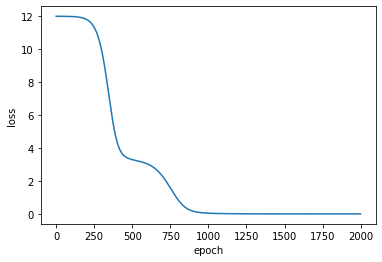

In [21]:
hist = mini_model.fit([mini_df.user, mini_df.item], mini_df.rating, epochs=2000, verbose=0) 
print('loss: ', hist.history['loss'][-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 미니 예측 (Predict)

이제 빵꾸난 별점을 예측해 보자  

In [22]:
Q = mini_model.get_layer(name='item_embedding').get_weights()[0]
P = mini_model.get_layer(name='user_embedding').get_weights()[0]
P_t = np.transpose(P)

R_hat = np.dot(Q, P_t)
pd.DataFrame(R_hat)

,0,1,2,3
0,4.999623,4.522830,1.008499,0.986881
1,4.741117,4.289957,1.006786,0.981370
2,5.235123,4.735589,1.041489,1.020268
3,1.000833,1.003219,5.234733,4.739758
4,1.001417,0.994072,4.737130,4.290676


In [23]:
print('뷰티 인사이드에 대한 Bob의 예상 별점은 {:.1f}'.format(R_hat[0][1]))
print('러브 스토리에 대한 Carol의 예상 별점은 {:.1f} 이다.'.format(R_hat[2][2]))

뷰티 인사이드에 대한 Bob의 예상 별점은 4.5
러브 스토리에 대한 Carol의 예상 별점은 1.0 이다.


⚙️ 엔지니어

> 실제 값과 가깝게 예측을 하고 있다!    


## 잠재 인수 모델링 (Latent Factor Modeling)

알고 있는 데이터세트($X, Y$)를 학습하여 새로운 입력값($X_{new}$)에 대해 출력값($\hat Y$)을 예측하는 모델이 선형 회귀 모델이다. 잠재 인수 모델도 선형 회귀 모델과 비슷하게 손실함수를 정의하고 손실함수가 최소가 되는 $P$와 $Q$를 찾는 모델이다.  

### 손실함수 (Loss function)

잠재 인수 모델(Latent factor model)에서의 손실 함수(Loss function)는 **SSE(Sum of Squared Error)** 를 사용한다.  

$J(p, q) = {1 \over 2}\sum_{(i,j) \in R} (r_{ij} - q_i \cdot p_{j}^T)^2$  

여기에 과대적합(Overfitting)을 방지하기 위해서 **L2 Regularization** 을 추가한다.  

$\begin{align}
J(p, q) & = {1 \over 2}\sum_{(i,j) \in R} (r_{ij} - q_i \cdot p_{j}^T)^2 \\
 & + {1 \over 2}\lambda \sum_{i} ||q_i||^2 + {1 \over 2}\lambda \sum_{j} ||p_j||^2
\end{align}$  


### 최적화 (Optimization)

손실함수의 최소값을 찾기 위해서 **경사 하강법(Gradient Descent)** 을 적용한다.  

REPEAT(epoch) {

$\begin{align}
p: &= p-\alpha \dfrac{\partial J(p,q)}{\partial p} \\    
q: &= q-\alpha \dfrac{\partial J(p,q)}{\partial q}
\end{align}$    
}

$\alpha$: learining rate    

⚙️ 엔지니어

> 여기서는    
> SSE 대신에 MSE를  
> GD 대신에 Adam을 사용한다.  

### 정리  

잠재 인수 모델 (Latent factor model)을 만드는 방법을 정리해 보자.  

1. Item, User 값을 인덱스 값으로 변환한다.    
2. 잠재 인수(Latent factor)의 개수를 정한다.  
3. 잠재 인수(Latent factor)를 **임베딩(Embedding)** 한다.  
4. **벡터화(Flatten)** 해서 잠재 벡터(Latent vector)로 변환한다.     
5. $\hat R$를 Item과 User의 잠재 벡터의 **내적(dot)** 으로 설정한다.   
6. 손실 함수 (Loss function)를 정의한다. 여기서는 **평균 제곱 오차(mean squared error)** 를 사용한다.  
7. 옵티마이저(Optimizer)를 정의한다. 여기서는 **Adam** 을 사용한다.  
8. 반복할 회수(epoch)를 결정한다.  
9. 주어진 조건으로 모델을 최적화(fit) 시킨다.   

## 케라스(Keras)로 모델링(Modeling)

### 데이터 변환 및 분할

훈련 데이터는 `ratings_df`에서 랜덤하게 80%를 선택하고,  
테스트 데이터는 나머지 20%를 랜덤하게 선택한다.  

In [24]:
# Indexing userId and movieId
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings_df['userId'] = ratings_df['userId'].apply(lambda x: userid2idx[x])
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x: movieid2idx[x])

# Split train and test data
split = np.random.rand(len(ratings_df)) < 0.8

train_df = ratings_df[split]
test_df = ratings_df[~split]

print('shape of train data is ',train_df.shape)
print('shape of test data is ',test_df.shape)

shape of train data is  (80544, 4)
shape of test data is  (20292, 4)


### 임베딩 (Embedding)

잠재 인수 개수를 64개로 하자.  

In [25]:
n_movies = len(ratings_df.movieId.unique())
n_users = len(ratings_df.userId.unique())
n_latent_factors = 64

movie_input = Input(shape=[1])
# Item latent factor
movie_embedding = Embedding(n_movies, n_latent_factors,
                           name='movie_embedding')(movie_input)

user_input = Input(shape=[1])
# User latent factor
user_embedding = Embedding(n_users, n_latent_factors,
                           name='user_embedding')(user_input)

### 벡터화 (Flatten)

In [26]:
# Item latent vector
movie_vec = Flatten()(movie_embedding)
# User latent vector
user_vec = Flatten()(user_embedding)

### 모델링 (Modeling)

In [27]:
r_hat = dot([movie_vec, user_vec], axes=-1)
model = Model([user_input, movie_input], r_hat)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### 모델 훈련 및 평가 (Train & Test Model)

⚙️ 엔지니어

> 돌려놓고 커피 한잔 하세여~

train loss:  0.015632702463206954
test loss:  1.4420501856603685


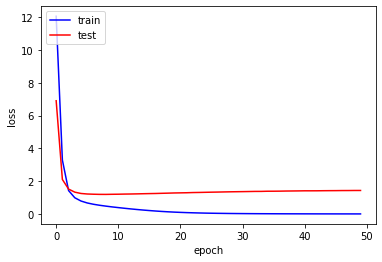

In [28]:
hist = model.fit([train_df.userId, train_df.movieId], train_df.rating, 
                 batch_size=128, epochs=50, verbose=0, 
                 validation_data = ([test_df.userId, test_df.movieId],test_df.rating)) 
print('train loss: ', hist.history['loss'][-1])
print('test loss: ', hist.history['val_loss'][-1])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['val_loss'] , 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

⚙️ 엔지니어

> 음...  
> 개선 사항이 보이지만  
> 오늘은 여기까지 하자  

## 해결 (Solution)

⚙️ 엔지니어  

> 보스~ 원하시는 솔루션입니다.      
>
> userId, movieId 값을 입력하시면    
> 예상되는 별점값이 출력 됩니다.   



In [29]:
userId = 214       # 1 ~ 610
movieId = 1059  # 1 ~ 193609
movie_title = list(movies_df[movies_df['movieId']==movieId].title)[0]

user_v = np.expand_dims(userid2idx[userId], 0)
movie_v = np.expand_dims(movieid2idx[movieId], 0)
predict = model.predict([user_v, movie_v])

print('영화 {} 에 대한 사용자 ID {}님의 예상 별점은 {:.1f} 입니다.'.format(movie_title, userId, predict[0][0]))

영화 William Shakespeare's Romeo + Juliet (1996) 에 대한 사용자 ID 214님의 예상 별점은 4.0 입니다.
